In [156]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch
import numpy as np
from scipy.ndimage import gaussian_filter

In [18]:
URL = "http://localhost:8080"

## Funkcje pomocniczne

In [135]:
def fetchCompetitions()->pd.DataFrame:
    return pd.DataFrame(requests.get(url=URL + "/competitions").json())

In [28]:
def fetchMatches(seasonID: int, competitonID: int)->pd.DataFrame:
    return pd.DataFrame(requests.get(url=URL + "/matches", params={"competitionID":competitonID, "seasonID":seasonID}).json())

In [111]:
def fetchEvents(eventID: int, stat: str, playerID:int = -1)->pd.DataFrame:
    return pd.DataFrame(requests.get(url=URL + "/events", params={"eventID":eventID,"stat":stat, "player_id":playerID}).json())

In [154]:
def visualisePasses(startLocations: np.ndarray, endLocations: np.ndarray, passCompletion: np.ndarray)->None:
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
    startX = np.array(startLocations.tolist())[:, 0]
    startY = np.array(startLocations.tolist())[:, 1]
    endX = np.array(endLocations.tolist())[:, 0]
    endY = np.array(endLocations.tolist())[:, 1]
    completed = passCompletion == "Completed"
    not_completed = ~completed
    pitch.arrows(startX[completed], startY[completed],
            endX[completed], endY[completed],
            capstyle='butt',
            color="blue",
              width=2 ,  # cut-off the line at the end-location.
            ax=ax['pitch'])
    pitch.arrows(startX[not_completed], startY[not_completed],
            endX[not_completed], endY[not_completed],
            capstyle='butt',
            color="red",
              width=2 ,  # cut-off the line at the end-location.
            ax=ax['pitch'])
    pitch.draw(ax=ax["pitch"])


In [160]:
def heatmap(locations: np.ndarray)->None:
    locx = np.array(locations.tolist())[:, 0]
    locy = np.array(locations.tolist())[:, 1]
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
    # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    bin_statistic = pitch.bin_statistic(locx, locy, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

In [207]:
def shotMap(locations: np.ndarray, is_goal: np.ndarray)->None:
    locx = np.array(locations.tolist())[:,1]
    locy = np.array(locations.tolist())[:, 2]
    xmax = np.max(locx)
    xmin = np.min(locx)
    ymax = np.max(locy)
    plt.figure(figsize=(10,5))
    plt.xlim((min(xmin, 35), max(xmax, 45)))
    plt.ylim((0, max(ymax, 3)))
    plt.vlines([36, 44], ymin=0, ymax=2.67, colors="black")
    plt.hlines(2.67, 36, 44, colors="black")
    goal = is_goal == 1
    no_goal = ~goal

    plt.scatter(locx[goal],locy[goal], color="green", s=50)
    plt.scatter(locx[no_goal], locy[no_goal],color="red", s=50)
    plt.show()


## Wizualizacja

In [144]:
locations = fetchEvents(eventID=3895302, playerID=34870, stat="position")

In [152]:
pass_localizations = fetchEvents(eventID=3895302, playerID=40724, stat="pass_localizations")

In [198]:
shots_localizations = fetchEvents(eventID=3895302, playerID=40724, stat="shot_localizations")
filtered_shots_localizations = shots_localizations[shots_localizations['end_location'].apply(len) == 3]
filtered_shots_localizations

,team_name,player_id,player_name,start_location,end_location,outcome,is_goal
0,Bayer Leverkusen,40724,Florian Wirtz,"[93.8, 34.8]","[120.0, 44.7, 1.3]",Off T,0
2,Bayer Leverkusen,40724,Florian Wirtz,"[93.5, 40.1]","[120.0, 40.2, 2.3]",Goal,1
3,Bayer Leverkusen,40724,Florian Wirtz,"[103.6, 35.0]","[120.0, 37.9, 0.6]",Goal,1
4,Bayer Leverkusen,40724,Florian Wirtz,"[106.4, 48.8]","[120.0, 37.7, 0.3]",Goal,1


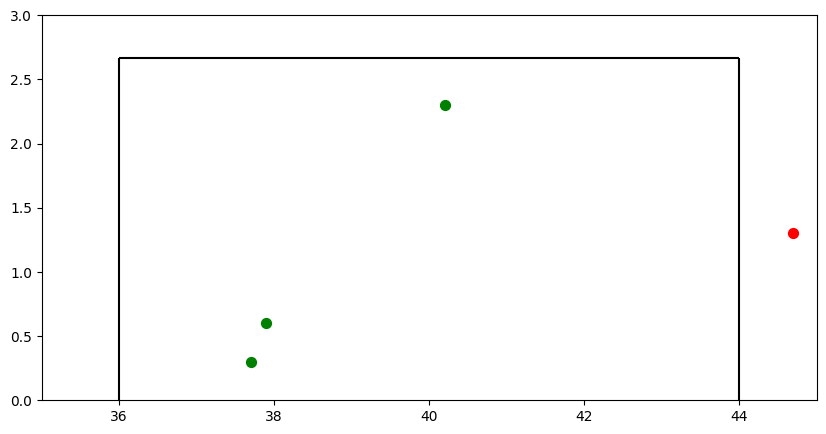

In [208]:
shotMap(filtered_shots_localizations["end_location"].to_numpy(), filtered_shots_localizations["is_goal"].to_numpy())

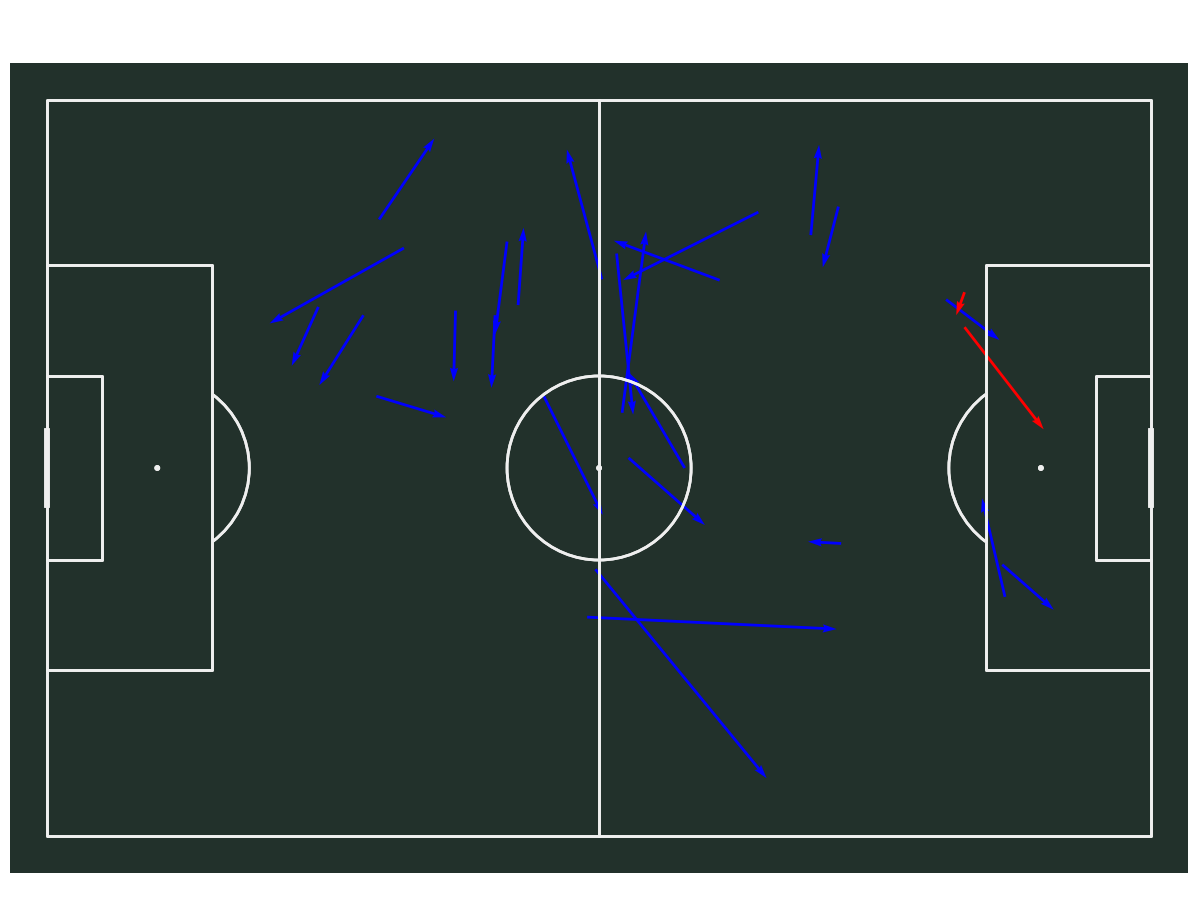

In [155]:
visualisePasses(pass_localizations["start_location"].to_numpy(),pass_localizations["end_location"].to_numpy(),pass_localizations["outcome"].to_numpy())

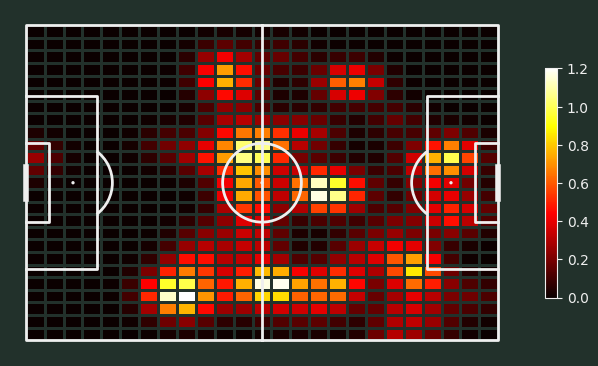

In [158]:
heatmap(locations["location"].to_numpy())